# Auto-Sklearn based Prostate Cancer analysis


## 1. system enviroment preparation

In order to run this code, we are going to first install Auto-sklearn using pip. For more instructions on how to install Auto-sklearn, for example using conda, please check [this](https://automl.github.io/auto-sklearn/master/installation.html).

**NOTE: Installation will take ~5mins. This is the perfect opportunity to introduce yourself to your team and tell them what you're working on!**

In [ ]:
!pip uninstall --yes nvidia-ml-py3 pandas-profiling scipy
!pip install pandas-profiling auto-sklearn==0.15.0 shap
!pip install -U numpy==1.23.5
print("Done! Please restart the Notebook (Runtime -> Restart Runtime)")

In [1]:
# load the data
import pandas as pd
import os
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

In [2]:
def scoring_function(estimator):        
    predictions = estimator.predict_proba(X_test)[:, 1]
    return sklearn.metrics.roc_auc_score(y_test, predictions)

def train_scoring_function(estimator):        
    predictions = estimator.predict_proba(X_train)[:, 1]
    return sklearn.metrics.roc_auc_score(y_train, predictions)

## 2. load raw data

In [3]:
dataset_name = "prostate-sp"
pd.set_option('display.width', 120)

In [4]:
# Set the path to the Excel file
data_dir = "/home/peng/Documents/00_Project/01_prostate/data"  # Replace with your actual data directory
metabolomics_file_name = "EDRN_MetabolomicsData_2023_08_27.xlsx"  # Replace with your actual file name
metabolomics_file_path = os.path.join(data_dir, metabolomics_file_name)
clinical_file_name = "EDRN_ClinicalData.xlsx"  # Replace with your actual file name
clinical_file_path = os.path.join(data_dir, clinical_file_name)

# Load the data from the Excel file
sheet_name = "PreprocessedData" 
metabolomics_df = pd.read_excel(metabolomics_file_path,sheet_name=sheet_name)

# Load the data from the Excel file
sheet_name = 1
clinical_df_raw = pd.read_excel(clinical_file_path,sheet_name=sheet_name)

In [5]:
# 打印前几行数据以确认
print(clinical_df_raw.head())

# 计算每列的空值比例
null_ratio = clinical_df_raw.isnull().mean()

# 过滤出空值比例在 2% 以下的列
columns_to_keep = null_ratio[null_ratio < 0.02].index

# 创建一个新的 DataFrame，仅包含这些列
clinical_df = clinical_df_raw[columns_to_keep]

# 打印新的 DataFrame 的前几行数据以确认
print(clinical_df.head())

  SAMPLE_ID  PreviousPositiveBiopsy  Age  EthnicityLatino  Ethnicity EthnicityOtherDesc  Employment  \
0    C00002                       0   77                0          1                NaN          10   
1    C00003                       0   78                0          1                NaN           6   
2    C00005                       0   63                0          1                NaN           1   
3    C00008                       0   58                0          1                NaN           6   
4    C00009                       0   71                0          1                NaN           6   

  EmploymentOtherDesc  Education  SmokingEver  ...  BiopsyComments2.RB  Tstage.RB  Nstage.RB  Mstage.RB  \
0            Seasonal          2            1  ...                 NaN        NaN        NaN        NaN   
1                 NaN          6            1  ...                 NaN        NaN        NaN        NaN   
2                 NaN          5            1  ...          

In [6]:
# 合并两个 DataFrame，保留所有行
merged_df = pd.merge(clinical_df,metabolomics_df , left_on='SAMPLE_ID', right_on='CLIENT_SAMPLE_ID', how='outer', indicator=True)
# 查找 SAMPLE_ID 和 CLIENT_SAMPLE_ID 不同的行
different_rows = merged_df[merged_df['_merge'] != 'both']
# 打印不同的行
print("Rows with different SAMPLE_ID and CLIENT_SAMPLE_ID:")
print(different_rows)
clinical_df = clinical_df[~clinical_df['SAMPLE_ID'].isin(different_rows['SAMPLE_ID'])]


Rows with different SAMPLE_ID and CLIENT_SAMPLE_ID:
    SAMPLE_ID  PreviousPositiveBiopsy  Age  EthnicityLatino  Ethnicity  Employment  Education  SmokingEver  \
15     C00026                       0   65                0          1           6          6            1   
18     C00031                       0   65                0          1           1          6            1   
582    C00930                       0   59                1          1          10          3            1   
583    C01019                       0   56                0          2           1          4            0   

     FamilyHistoryPrCa  PreviousCancer  ...  bilirubin degradation product, C17H20N2O5 (2)**  \
15                   0               0  ...                                              NaN   
18                   0               0  ...                                              NaN   
582                  0               0  ...                                              NaN   
583          

In [7]:
columns_to_keep=['SAMPLE_ID','Diagnosis','PreviousCancer','Age','PreBioPSA','FamilyHistoryPrCa','AbnormDRE']
clinical_df_filtered=clinical_df[columns_to_keep]

# 合并数据，保留相同的行
merged_df = pd.merge(clinical_df_filtered, metabolomics_df, left_on='SAMPLE_ID', right_on='CLIENT_SAMPLE_ID')
columns_to_drop = ['SAMPLE_ID', 'CLIENT_SAMPLE_ID']  # 替换为你想要删除的列名
data_df_raw = merged_df.drop(columns=columns_to_drop)

## 3. select data

In [8]:
# data=data_df_raw[data_df_raw['PreviousCancer'] == 0]
data=data_df_raw

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_114917/1613188945.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Diagnosis', y='PreviousCancer', data=data, palette='Set2')


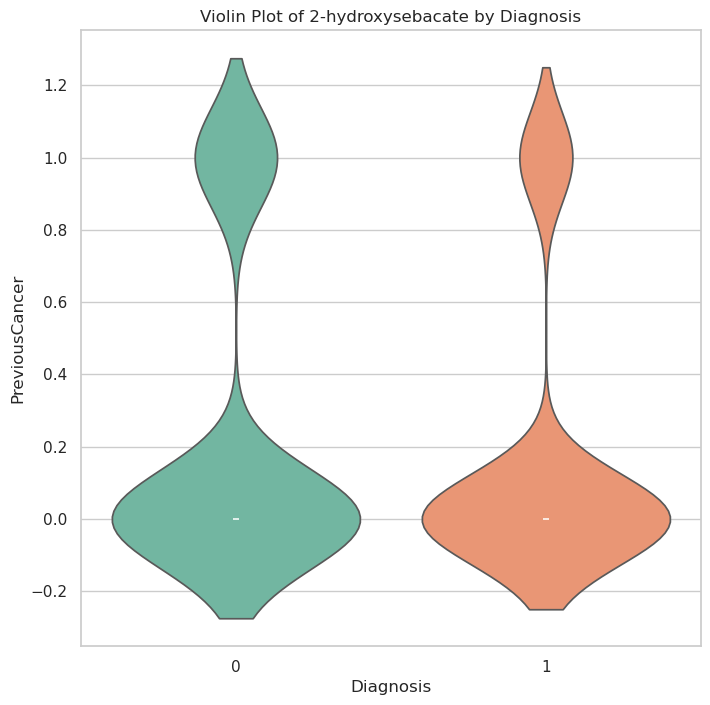

In [10]:
# 设置绘图风格
sns.set(style="whitegrid")
# 绘制点状图
plt.figure(figsize=(8, 8))
sns.violinplot(x='Diagnosis', y='PreviousCancer', data=data, palette='Set2')
plt.title('Violin Plot of 2-hydroxysebacate by Diagnosis')
plt.show()

## 4. preprocess data



### 4.1 ceate X and y

In [164]:
columns_to_drop=['Diagnosis','PreviousCancer','Age','PreBioPSA','FamilyHistoryPrCa','AbnormDRE']
# columns_to_drop=['Diagnosis','Age']
X=data.drop(columns=columns_to_drop)
columns_to_keep=['Diagnosis']
y=data[columns_to_keep]

### 4.2 t-test

In [165]:
from scipy.stats import shapiro, normaltest, ttest_ind, mannwhitneyu

# 对每一列进行正态性检验
normality_results = {}

for column in X.columns:
    # 使用 Shapiro-Wilk 检验
    stat, p_value = shapiro(X[column].dropna())
    normality_results[column] = {'Shapiro-Wilk': {'statistic': stat, 'p_value': p_value}}
    
    # # 使用 D'Agostino 和 Pearson 的正态性检验
    # stat, p_value = normaltest(X_raw[column].dropna())
    # normality_results[column].update({'D\'Agostino-Pearson': {'statistic': stat, 'p_value': p_value}})

# 打印结果
# for column, results in normality_results.items():
#     print(f"Column: {column}")
#     for test, result in results.items():
#         print(f"  {test} test: statistic={result['statistic']}, p_value={result['p_value']}")
#     print()


In [166]:
# 根据正态性检验结果选择检验方法
test_results = {}
p_values = {}
for column in X.columns:
    # 获取分组数据
    group1 = X[column][y['Diagnosis'] == 0].dropna()
    group2 = X[column][y['Diagnosis'] == 1].dropna()
    
    # 判断是否符合正态分布
    if normality_results[column]['Shapiro-Wilk']['p_value'] > 0.05:
        # 符合正态分布，使用 t 检验
        stat, p_value = ttest_ind(group1, group2)
        test_results[column] = {'Test': 't-test', 'statistic': stat, 'p_value': p_value}
    else:
        # 不符合正态分布，使用 Mann-Whitney U 检验
        stat, p_value = mannwhitneyu(group1, group2)
        test_results[column] = {'Test': 'Mann-Whitney U', 'statistic': stat, 'p_value': p_value}
    
    # 收集 p 值
    p_values[column] = p_value

In [167]:
# 删除 p 值高于 0.05 的列
threshold = 0.2

p_values_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'P-Value'])
p_values_sorted_df = p_values_df.sort_values(by='P-Value', ascending=True)
p_values_sorted_df.to_excel('p_values_sorted.xlsx')

p_values_ttest_df = p_values_df[p_values_df['P-Value'] < threshold]
p_values_ttest_sorted_df = p_values_ttest_df.sort_values(by='P-Value', ascending=True)
p_values_ttest_sorted_df.to_excel('p_values_sorted.xlsx')

columns_to_keep = [column for column, p_value in p_values.items() if p_value <= threshold]
X_ttest = X[columns_to_keep]

sorted_features = p_values_ttest_sorted_df['Feature']
X_ttest_sorted = X_ttest[sorted_features]

data_ttest_sorted_df = pd.concat([y, X_ttest_sorted], axis=1)
data_ttest_sorted_df.to_excel('data_filtered_sorted_df.xlsx')

### 4.3 corr

In [168]:
# 计算相关性矩阵
correlation_matrix = X_ttest_sorted.corr()

# 设置相关性阈值
correlation_threshold = 0.3

# 找到相关性高的列对
high_correlation_pairs = set()
for column in correlation_matrix.columns:
    for index in correlation_matrix.index:
        if column != index and abs(correlation_matrix.loc[index, column]) > correlation_threshold:
            high_correlation_pairs.add((index, column))

# 找到需要删除的列
columns_to_drop = set()
for col1, col2 in high_correlation_pairs:
    # 选择一个列名加入删除列表，这里选择 col2
    if p_values[col1] > p_values[col2]:
        columns_to_drop.add(col1)
    else:
        columns_to_drop.add(col2)

# 删除相关性高的列
X_ttest_corr_sorted= X_ttest_sorted.drop(columns=columns_to_drop)

data_ttest_corr_sorted_df = pd.concat([y, X_ttest_corr_sorted], axis=1)
# # data_ttest_corr_sorted_df.to_excel('data_ttest_corr_sorted_df.xlsx')
# # 打印删除列后的 DataFrame
# print("DataFrame after dropping highly correlated columns:")
# print(X_ttest_corr_sorted.head())

### 4.4: variance threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
# 设置方差阈值
variance_threshold = 0.5  # 你可以根据需要调整这个阈值

# 使用 VarianceThreshold 进行特征选择
selector = VarianceThreshold(threshold=variance_threshold)
X_ttest_corr_var = selector.fit_transform(X_ttest_corr_sorted)

# 获取保留的列名
columns_to_keep = X_ttest_corr_sorted.columns[selector.get_support(indices=True)]

# 创建新的 DataFrame，保留方差高的列
X_ttest_corr_var_sorted = pd.DataFrame(X_ttest_corr_var, columns=columns_to_keep)

# 打印删除列后的 DataFrame
print("DataFrame after dropping low variance columns:")
print(X_ttest_corr_var_sorted.head())

In [170]:
X_ttest_corr_var_sorted['PreviousCancer'] =data['PreviousCancer']
# X_ttest_corr_var_sorted['Age'] =data['Age']
# X_ttest_corr_var_sorted = X_ttest_corr_var_sorted.drop(columns=['Age'])
X_ttest_corr_var_sorted['PreBioPSA'] = data['PreBioPSA']
X_ttest_corr_var_sorted['FamilyHistoryPrCa'] = data['FamilyHistoryPrCa']
# X_ttest_corr_var_sorted['AbnormDRE'] = data['AbnormDRE']


In [299]:
X_ttest_corr_var_sorted = X_ttest_corr_var_sorted.drop(columns=['Age'])


In [263]:
X_ttest_corr_var_sorted['PreviousCancer'] = data['PreviousCancer']

In [309]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_ttest_corr_var_sorted,
    y,
    random_state=0,
    stratify=y,
)

In [3]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import roc_auc

# Edit the settings to try in both AutoSklearn1 and AutoSklearn2
# Possibilities https://automl.github.io/auto-sklearn/master/api.html

#------------------------- edit code here
settings = {
  "time_left_for_this_task": 120,  # seconds
  "per_run_time_limit": 15,  # seconds
  "seed": 0,
  "metric": roc_auc,
  "memory_limit": 16384,
  "n_jobs": 8,
}

# This will only be used by autosklearn 1 while autosklearn 2 will automatically
# select a strategy
resampling_strategy = "holdout"

In [4]:
# Create and train AutoSklearn2.0 
askl2 = AutoSklearn2Classifier(**settings)
askl2.fit(X_train, y_train, dataset_name="prostate-sp")

NameError: name 'X_train' is not defined

In [312]:
prediction = askl2.predict_proba(X_test)
performance = roc_auc_score(y_test, prediction[:, 1])
print(f"askl2 performance is {performance}")

askl2 performance is 0.7701875239188671


In [ ]:
# Print statistics about the auto-sklearn run such as number of
# iterations, number of models failed with a time out.
print(askl2.sprint_statistics())

In [ ]:
# Print the final ensemble constructed by auto-sklearn via random search.
from pprint import pprint
pprint(askl2.show_models(), indent=4)

# 5. optimization parameters

In [73]:
import numpy as np
ttest_thresholds = np.arange(0.05, 0.2, 0.05)
correlation_thresholds = np.arange(0.3, 0.9, 0.1)
variance_thresholds = np.arange(0.1, 0.9, 0.1)

In [ ]:
# 初始化结果列表
results = []

for ttest_threshold in ttest_thresholds:
    for correlation_threshold in correlation_thresholds:
        for variance_threshold in variance_thresholds:
            
            # 特征选择

            # t 检验
            # p_values_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'P-Value'])
            # p_values_sorted_df = p_values_df.sort_values(by='P-Value', ascending=True)
            # # p_values_sorted_df.to_excel('p_values_sorted.xlsx')

            p_values_ttest_df = p_values_df[p_values_df['P-Value'] < ttest_threshold]
            p_values_ttest_sorted_df = p_values_ttest_df.sort_values(by='P-Value', ascending=True)
            # p_values_ttest_sorted_df.to_excel('p_values_sorted.xlsx')

            columns_to_keep = [column for column, p_value in p_values.items() if p_value <= ttest_threshold]
            X_ttest = X[columns_to_keep]

            sorted_features = p_values_ttest_sorted_df['Feature']
            X_ttest_sorted = X_ttest[sorted_features]

            # data_ttest_sorted_df = pd.concat([y, X_ttest_sorted], axis=1)


            # 计算相关性矩阵
            correlation_matrix = X_ttest_sorted.corr()
            # 设置相关性阈值
            # correlation_threshold = 0.7
            # 找到相关性高的列对
            high_correlation_pairs = set()
            for column in correlation_matrix.columns:
                for index in correlation_matrix.index:
                    if column != index and abs(correlation_matrix.loc[index, column]) > correlation_threshold:
                        high_correlation_pairs.add((index, column))

            # 找到需要删除的列
            columns_to_drop = set()
            for col1, col2 in high_correlation_pairs:
                # 选择一个列名加入删除列表，这里选择 col2
                if p_values[col1] > p_values[col2]:
                    columns_to_drop.add(col1)
                else:
                    columns_to_drop.add(col2)

            # 删除相关性高的列
            X_ttest_corr_sorted= X_ttest_sorted.drop(columns=columns_to_drop)

            # data_ttest_corr_sorted_df = pd.concat([y, X_ttest_corr_sorted], axis=1)


            # 使用 VarianceThreshold 进行特征选择
            # 设置方差阈值
            # variance_threshold = 0.5  # 你可以根据需要调整这个阈值

            # 使用 VarianceThreshold 进行特征选择
            selector = VarianceThreshold(threshold=variance_threshold)
            X_ttest_corr_var = selector.fit_transform(X_ttest_corr_sorted)

            # 获取保留的列名
            columns_to_keep = X_ttest_corr_sorted.columns[selector.get_support(indices=True)]

            # 创建新的 DataFrame，保留方差高的列
            X_ttest_corr_var_sorted = pd.DataFrame(X_ttest_corr_var, columns=columns_to_keep)

            X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
                X_ttest_corr_var_sorted,
                y,
                random_state=0,
                stratify=y,
                )


            # 训练 AutoSklearn2Classifier
            askl2 = AutoSklearn2Classifier(**settings)
            askl2.fit(X_train, y_train, dataset_name="prostate-sp")
            
            # 预测和评估
            prediction = askl2.predict_proba(X_test)
            performance = roc_auc_score(y_test, prediction[:, 1])
            
            # 保存结果
            results.append({
                'ttest_threshold': ttest_threshold,
                'correlation_threshold': correlation_threshold,
                'variance_threshold': variance_threshold,
                'accuracy': performance
            })

In [82]:
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['accuracy'].idxmax()]


# 6. clinical features optimization

In [279]:
import itertools

# 定义要尝试的列
columns_to_try = ['PreviousCancer', 'PreBioPSA', 'FamilyHistoryPrCa', 'AbnormDRE','Age']  # 替换为实际的列名 columns_to_drop=['Diagnosis','PreviousCancer','Age','PreBioPSA','FamilyHistoryPrCa','AbnormDRE']
# 初始化结果列表
results_cf = []

# 遍历所有列的组合
for r in range(1, len(columns_to_try) + 1):
    for combination in itertools.combinations(columns_to_try, r):
        # 选择列组合
        X=X_ttest_corr_var_sorted.iloc[:, 0:23]
        X[list(combination)] = data[list(combination)]
        # 分割数据集
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
            X,
            y,
            random_state=0,
            stratify=y,
        )
        # 训练 AutoSklearn2Classifier
        askl2 = AutoSklearn2Classifier()
        # Create and train AutoSklearn2.0 
        askl2 = AutoSklearn2Classifier(**settings)
        askl2.fit(X_train, y_train, dataset_name="prostate-sp")
        # 预测和评估
        prediction = askl2.predict_proba(X_test)
        performance = roc_auc_score(y_test, prediction[:, 1])
        
        # 保存结果
        results_cf.append({
            'combination': combination,
            'performance': performance
        })

# 转换结果为 DataFrame
results_cf_df = pd.DataFrame(results_cf)

# 找到表现最好的组合
best_result_cf = results_cf_df.loc[results_cf_df['performance'].idxmax()]

# 打印结果
print("Results:")
print(results_cf_df)
print("Best result:")
print(best_result_cf)

/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:20:19,089:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:22:13,354:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:22:13,439:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:24:07,726:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:26:02,728:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:27:56,287:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:29:51,051:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:31:44,587:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:31:44,639:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:33:38,617:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():
/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:37:27,434:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:37:27,517:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:39:21,426:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:39:21,514:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:41:15,927:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:43:10,920:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:43:10,999:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:45:05,263:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:45:05,312:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:46:59,803:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:46:59,867:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:48:54,161:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:48:54,253:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:50:47,743:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:52:47,469:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:54:42,167:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:56:36,469:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 20:58:32,347:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 20:58:32,418:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:00:25,786:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:02:20,460:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 21:02:20,542:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:04:15,071:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:06:09,530:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:08:03,157:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:09:56,774:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:11:50,799:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:13:48,844:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 21:13:48,916:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:15:43,749:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 21:15:43,836:Client-EnsembleBuilder] No runs were available to build an ensemble from


/home/peng/opt/anaconda3/envs/autosl/lib/python3.9/site-packages/autosklearn/experimental/selector.py:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, series in prediction.iteritems():


[WARNING] [2024-11-06 21:17:38,876:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2024-11-06 21:17:38,958:Client-EnsembleBuilder] No runs were available to build an ensemble from
Results:
                                          combination  performance
0                                   (PreviousCancer,)     0.733448
1                                        (PreBioPSA,)     0.740719
2                                (FamilyHistoryPrCa,)     0.707042
3                                        (AbnormDRE,)     0.712400
4                                              (Age,)     0.728856
5                         (PreviousCancer, PreBioPSA)     0.751052
6                 (PreviousCancer, FamilyHistoryPrCa)     0.703406
7                         (PreviousCancer, AbnormDRE)     0.724646
8                               (PreviousCancer, Age)     0.730769
9                      (PreBioPSA, FamilyHistoryPrCa)     0.736318
10                             (PreBio

### 1d) Visualize Data (Optional) 

In [ ]:
complete_df = pd.concat([y_train, X_train], axis=1)
complete_df.describe(include='all')

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

# 设置绘图风格
sns.set(style="whitegrid")
# 绘制点状图
plt.figure(figsize=(8, 8))
sns.violinplot(x='Diagnosis', y='2-hydroxysebacate', data=complete_df, palette='Set2')
plt.title('Violin Plot of 2-hydroxysebacate by Diagnosis')
plt.show()

# stats step 1: t-test

In [ ]:
from scipy.stats import shapiro, normaltest, ttest_ind, mannwhitneyu

# 对每一列进行正态性检验
normality_results = {}

for column in X.columns:
    # 使用 Shapiro-Wilk 检验
    stat, p_value = shapiro(X[column].dropna())
    normality_results[column] = {'Shapiro-Wilk': {'statistic': stat, 'p_value': p_value}}
    
    # 使用 D'Agostino 和 Pearson 的正态性检验
    stat, p_value = normaltest(X[column].dropna())
    normality_results[column].update({'D\'Agostino-Pearson': {'statistic': stat, 'p_value': p_value}})

# 打印结果
for column, results in normality_results.items():
    print(f"Column: {column}")
    for test, result in results.items():
        print(f"  {test} test: statistic={result['statistic']}, p_value={result['p_value']}")
    print()

In [28]:
# 根据正态性检验结果选择检验方法
test_results = {}
p_values = {}
for column in X.columns:
    # 获取分组数据
    group1 = X[column][y['Diagnosis'] == 0].dropna()
    group2 = X[column][y['Diagnosis'] == 1].dropna()
    
    # 判断是否符合正态分布
    if normality_results[column]['Shapiro-Wilk']['p_value'] > 0.05:
        # 符合正态分布，使用 t 检验
        stat, p_value = ttest_ind(group1, group2)
        test_results[column] = {'Test': 't-test', 'statistic': stat, 'p_value': p_value}
    else:
        # 不符合正态分布，使用 Mann-Whitney U 检验
        stat, p_value = mannwhitneyu(group1, group2)
        test_results[column] = {'Test': 'Mann-Whitney U', 'statistic': stat, 'p_value': p_value}
    
    # 收集 p 值
    p_values[column] = p_value

In [29]:
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Feature', 'P-Value'])


In [74]:
p_values_sorted_df = p_values_df.sort_values(by='P-Value', ascending=True)

In [75]:
p_values_sorted_df.to_excel('p_values_sorted.xlsx')

In [76]:
# 删除 p 值高于 0.05 的列
threshold = 0.2
p_values_df_filtered = p_values_df[p_values_df['P-Value'] < threshold]

In [77]:
p_values_df_filtered_sort = p_values_df_filtered.sort_values(by='P-Value', ascending=True)

In [78]:
p_values_df_filtered_sort.to_excel('p_values_sorted.xlsx')

In [79]:

columns_to_keep = [column for column, p_value in p_values.items() if p_value <= threshold]
X_filtered = X[columns_to_keep]


In [80]:
p_values_df_filtered = p_values_df[p_values_df['P-Value'] < threshold]
sorted_features = p_values_df_filtered_sort['Feature']
X_filtered_sorted = X_filtered[sorted_features]


In [81]:
data_filtered_sorted_df = pd.concat([y, X_filtered_sorted], axis=1)
data_filtered_sorted_df.to_excel('data_filtered_sorted_df.xlsx')

# stats step 2: corr

In [ ]:

# 计算相关性矩阵
correlation_matrix = X_filtered.corr()

# 设置相关性阈值
correlation_threshold = 0.7

# 找到相关性高的列对
high_correlation_pairs = set()
for column in correlation_matrix.columns:
    for index in correlation_matrix.index:
        if column != index and abs(correlation_matrix.loc[index, column]) > correlation_threshold:
            high_correlation_pairs.add((index, column))

# 找到需要删除的列
columns_to_drop = set()
for col1, col2 in high_correlation_pairs:
    # 选择一个列名加入删除列表，这里选择 col2
    if p_values[col1] > p_values[col2]:
        columns_to_drop.add(col1)
    else:
        columns_to_drop.add(col2)

# 删除相关性高的列
X_corr_filtered= X_filtered.drop(columns=columns_to_drop)

# 打印删除列后的 DataFrame
print("DataFrame after dropping highly correlated columns:")
print(X_corr_filtered.head())

# stats step 2: variance threshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
# 设置方差阈值
variance_threshold = 0.4  # 你可以根据需要调整这个阈值

# 使用 VarianceThreshold 进行特征选择
selector = VarianceThreshold(threshold=variance_threshold)
X_corr_var_selected = selector.fit_transform(X_corr_filtered)

# 获取保留的列名
columns_to_keep = X_corr_filtered.columns[selector.get_support(indices=True)]

# 创建新的 DataFrame，保留方差高的列
X_corr_var = pd.DataFrame(X_corr_var_selected, columns=columns_to_keep)

# 打印删除列后的 DataFrame
print("DataFrame after dropping low variance columns:")
print(X_corr_var.head())

In [16]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X_corr_var,
    y,
    random_state=0,
    stratify=y,
)

In [18]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import roc_auc

# Edit the settings to try in both AutoSklearn1 and AutoSklearn2
# Possibilities https://automl.github.io/auto-sklearn/master/api.html

#------------------------- edit code here
settings = {
  "time_left_for_this_task": 120,  # seconds
  "seed": 42,
  "metric": roc_auc,
  "memory_limit":16384,
  "n_jobs": 4,
}

# This will only be used by autosklearn 1 while autosklearn 2 will automatically
# select a strategy
resampling_strategy = "holdout"

In [ ]:
# Create and train AutoSklearn2.0 
askl2 = AutoSklearn2Classifier(**settings)
askl2.fit(X_train, y_train, dataset_name="prostate-sp")

In [20]:
X_test, y_test = get_test_data()
train_columns = X_train.columns
X_test = pd.DataFrame(X_test, columns=train_columns)

In [ ]:
from sklearn.metrics import roc_auc_score
prediction = askl2.predict_proba(X_test)
performance = roc_auc_score(y_test, prediction[:, 1])
print(f"askl2 performance is {performance}")

<a name="task1"></a>
# Task 1: Build your own pipeline (BYOP; 15 minutes)

❓ **Why:** Even if you use AutoML methods, you should still take some time to understand the data and the pipeline you're going to use.

📓 **What:** Build your own scikit-learn pipeline

  1. Pre-process categorical and continuous features (if necessary)
  2. Choose a model type and train a predictive model
  3. Compute the score for your model
  4. Discuss the questions below 🔽 with your team members

If you are not familiar with scikit-learn you can find further information in the [docs](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) and [examples](https://scikit-learn.org/stable/auto_examples/index.html#pipelines-and-composite-estimators).

✅ **Outcome:** Questions to be discussed:

  1. Which model class have you used?
  2. What was your score?

In [ ]:
# We'll start by checking out the effect of a OneHotEncoder
# First let's check out the distinct values of the "housing" and "own_telephone" columns
columns = ["housing", "own_telephone"] 
X_train[columns]

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Now lets see the effect of one hot encoding these columns and how that turns the
# distinct categoricals to numerical values we can feed to a machine learning pipeline
OHE = OneHotEncoder(handle_unknown='ignore')
raw_encoded_data = OHE.fit_transform(X_train[columns]).toarray()

# The OneHotEncoder will generate a new feature column per categoriy
# Let's see what these look like now that they're encoded
# This following line grabs the new encoded colun
encoded_columns = pd.DataFrame(
    raw_encoded_data,
    columns=OHE.get_feature_names(columns),
    dtype=int
)
encoded_columns

In [ ]:
# We'll now setup an sklearn pipeline that performs this OneHotEncoding
# to *all* the categorical columns and pass the numericals directly through to
# a model

# Import estimator and preprocessors you need
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Initialize your estimator
# Check the scikit-learn API for a complete list of classifier:
# https://scikit-learn.org/stable/supervised_learning.html
#------------------------- edit code here
estimator = DummyClassifier()


# Select the categorical columns to pass through our OneHotEncoder
categorical_selector = selector(dtype_include="category")
categorical_columns = categorical_selector(X_train)
print("Categorical Columns: ", categorical_columns)

# Select the numerical columns to 
numerical_selector = selector(dtype_exclude="category")
numerical_columns = numerical_selector(X_train)
print("Numerical Columns: ", numerical_columns)

# Build the ColumnTransformer which applies transformations to subsets of columns
# Feel free to include your own preprocessors
# https://scikit-learn.org/stable/modules/compose.html#column-transformer
preprocessor = ColumnTransformer(
    [
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('age', StandardScaler(), selector("age")),   
    ],
    remainder="passthrough"
)

# Assemble the pipeline with the preprocessor and the classifier
pipeline_byop = Pipeline([
  ('preprocessor', preprocessor),
  ('gradboost', estimator),
])
#-------------------------

pipeline_byop.fit(X_train, y_train)

# Show the prediction on the first 10 test instances
X_test, y_test = get_test_data()
predictions = pipeline_byop.predict(X_test) 

for prediction, actual_label in zip(predictions[:10], y_test[:10]):
   print(f"Predicted - {prediction:4} | actual - {actual_label}")

# Score the pipeline
performance_byop = train_scoring_function(pipeline_byop)
print(f"Train performance of my pipeline is {performance_byop}")

performance_byop = scoring_function(pipeline_byop)
print(f"Test performance of my pipeline is {performance_byop}")

<a name="task2"></a>
# Task 2: Auto-sklearn

❓ **Why:** You just manually built a predictive pipeline that works (pretty well). However this is for one specific dataset and with a very small _search space_ of what was tried.

Now you're ready to use Auto-sklearn. Can we automate **even more**?

📓 **What:** Run Auto-sklearn on a dataset, credit-g
  1. Run Auto-sklearn. Make sure that everyone at your table runs Auto-sklearn with a different setting, e.g. `resampling_strategy`, `ensemble_size`, `metric`,  (for more see [here](https://automl.github.io/auto-sklearn/master/api.html)).
     * While it's running, discuss how **you** would try automate the procedure from the previous exercise?
  2. Inspect the output
  3. Discuss the questions below 🔽 with your team members

✅ **Outcome:** While AutoML systems seemingly magically produce predictions, it is always a good to also understand how they work. Here are a few questions your boss, your client or your professor might ask you regarding using Auto-sklearn:

  * What pipelines were found? Was it better than your manual pipeline?
  * How pipelines did Auto-sklearn try?
  * AutoSklearn uses ensembling, what was the difference between the best model and the ensemble? How would you combine the different predictions of different piplines?
  * How did the different settings impact the result/statistics?
  * How would you search for different pipelines, how does AutoSklearn do it?
 
➕ **A Few Notes On Debugging**

Not everything works at the first try. Here are a few recommendations for [debugging](http://www.phdcomics.com/comics/archive/phd011406s.gif): 

  * Check the statistics: `estimator_askl.sprint_statistics()`
  * Check the evaluated models: `estimator_askl.show_models()`
  * Check the logs: Click the 📁 icon on the left, navigate to `/tmp/` and open the relevant Auto-sklearn logs in one of the `autosklearn_tmp_*` folders)
  * If nothing helps, try restarting the runtime and notebook
  * Do a factory reset as a last resort

#### Task 2a: Fitting Auto-sklearn

In [8]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc

In [82]:
def scoring_function(estimator):        
    predictions = estimator.predict_proba(X_test)[:, 1]
    return sklearn.metrics.roc_auc_score(y_test, predictions)

def train_scoring_function(estimator):        
    predictions = estimator.predict_proba(X_train)[:, 1]
    return sklearn.metrics.roc_auc_score(y_train, predictions)

In [14]:
# Edit the settings to try in both AutoSklearn
# Possibilities https://automl.github.io/auto-sklearn/master/api.html
#------------------------- edit code here
settings = {
  "time_left_for_this_task": 300, # Seconds
  "seed": 0,                      # The random seed to use
  "metric": roc_auc,              # What metric to optimize for
  "n_jobs": 4,                    # How many processes to use
  "ensemble_size": 10,            # How many models to put together for predictions
  "memory_limit":16384, 
  "resampling_strategy": "cv" # How to sample data internally for fitting models, "holdout" does a simple train-test splt, "cv" does cross-validation
}

Auto-sklearn follows the scikit-learn API to specify how to run in parallel by providing the argument `n_jobs`. If `n_jobs >= 1` the respective number of cores is used, for `n_jobs is None` 1 core is used and for `n_jobs < 0` all available cores are used. If you set `n_jobs != 1`, run Auto-sklearn on your local machine and have [Bokeh](https://bokeh.org/) installed, you also get access to the [Dask dashboard](https://docs.dask.org/en/stable/diagnostics-distributed.html) which shows how the individual training jobs of Auto-sklearn are executed in a distributed fashion.

Lets train AutoSklearn with these settings

In [ ]:
# Create and train an ensemble with AutoML 
# Auto-sklearn will take your data and automate your previous manual exploration
# This may take a while if you left the time at 300 seconds. This is a good time to:
#
# * Talk about how you would try automate this process
# * Checkout what arguments you can put in for settings: https://automl.github.io/auto-sklearn/master/api.html
#
askl = AutoSklearnClassifier(**settings)
askl.fit(X_train, y_train, dataset_name="credit-g")

In [ ]:
train_scoring_function(askl)

In [ ]:
scoring_function(askl)

In [85]:
from sklearn.metrics import roc_auc_score

In [ ]:
# Score the model

# prediction = askl.predict_proba(X_test)
performance = roc_auc_score(y_test, prediction[:, 1])
print(f" performance is {performance}")

Now lets take a look at the summary statistics!

In [ ]:
from pprint import pprint

print(f"Auto-sklearn | train = {train_scoring_function(askl)} | test = {scoring_function(askl)}")
print(f"Settings = {settings}")

# Some quick summary statistics
print("\nSummary")
print(askl.sprint_statistics())

# The leaderboard shows all the models during the optimization process,
# see this link for arguments if you want to see more!
# https://automl.github.io/auto-sklearn/master/api.html#autosklearn.classification.AutoSklearnClassifier.leaderboard
leaderboard = askl.leaderboard(
    sort_by="cost",
    ensemble_only=True,
    detailed=True
)

roc_auc_scores = 1 - leaderboard["cost"]
leaderboard.insert(loc=0, column=roc_auc.name, value=roc_auc_scores)
leaderboard

In [ ]:
# Show all the models in the final produced ensemble
pprint(askl.show_models())

<a name="Task3"></a>
# Task 3: Explainability

❓ **Why:** To understand what features are important for producing a prediction.

📓 **What:** Apply feature importance methods to Auto-Sklearn. Auto-sklearn behaves like a scikit-learn estimator and thus any method that works with an scikit-learn estimator also works with Auto-sklearn. The [`sklearn.inspection`](https://scikit-learn.org/stable/inspection.html) module offers some interesting features importance methods you can evaluate, and in this task you will use the permutation importance.

✅ **Outcome:** Discuss the questions below 🔽 with your team members


* Which features are important?
* Is anything striking about either of the plots?
* Can Auto-sklearn's design space be restricted to provide only interpretable models?
* What other feature importance methods could be applied (blackbox or whitebox)?

In [18]:
from sklearn.inspection import plot_partial_dependence, permutation_importance
import matplotlib.pyplot as plt
import numpy as np

**Note**: In order to compute meaningful explanations we need data that is distinct from the training data, in this case we re-purpose the test set. This will take roughly two minutes if you've used `resampling_strategy='cv'` and much less if you've used `resampling_strategy='holdout'`. If you have time, you can increase the number of repetitions to get more reliable feature importance scores. If applicable, you can also move from cross-validation to holdout to improve speed here.

While the code runs, you could for example [read up how feature importance](https://scikit-learn.org/stable/modules/permutation_importance.html) works.

In [ ]:
def get_data_for_feature_importance():
    # From OpenML: https://www.openml.org/d/31
    X, y = sklearn.datasets.fetch_openml('credit-g', as_frame=True, return_X_y=True)
    _, X_test, _, y_test = sklearn.model_selection.train_test_split(
      X, y, random_state=42
    )
    return X_test, y_test

X_feature_importance, y_feature_importance,  = get_data_for_feature_importance()

r = permutation_importance(
    askl, X_feature_importance, y_feature_importance,
    n_repeats=2, random_state=0, n_jobs=-1,
    scoring='roc_auc',
)

In [ ]:
%matplotlib inline
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sort_idx = r.importances_mean.argsort()
ax.boxplot(r.importances[sort_idx].T, labels=[X_train.columns[i] for i in sort_idx], vert=False)
fig.show()
plt.show()

[PD plots](https://christophm.github.io/interpretable-ml-book/pdp.html) describe the relation between feature values and the response value, i.e. the expected response value wrt. one or multiple input features. Since we use a classification dataset, this corresponds to the predicted class probability.

Unfortunatly this only works for numerical features and so we use the 2 numerical features which were considered the most important for classification.

In [ ]:
from sklearn.inspection import plot_partial_dependence

features = ["duration", "age"]

plot_partial_dependence(
    askl,
    X_test,
    features=features,
    grid_resolution=5,
    kind="both",
    feature_names=X_test.columns,
)
plt.tight_layout()
plt.show()

##### Other explainers

* Can use anything that works with sklearn
* [SHAP](https://github.com/slundberg/shap) can only be used for datasets without categorical features and without missing values
* We have such examples in a [EuroPython tutorial notebook](https://github.com/automl/auto-sklearn-talks/blob/main/2021_07_28_EuroPython/Tutorial-Regression.ipynb) and the [Auto-sklearn examples](https://automl.github.io/auto-sklearn/master/examples/40_advanced/example_inspect_predictions.html)

In [ ]:
leaderboard = custom_metric_askl.leaderboard()
leaderboard[scorer.name] = 1 - leaderboard["cost"]
leaderboard

<a name="task6"></a>
# Task 6: AutoSklearn 2.0

❓ **Why**: Selecting a good validation strategy is crucial to not overfit to the data at hand, specifically with smaller datasets. However choosing the right validation strategy is a hard task. Why not automate this? AutoSklearn 2.0 does this with meta-learning!

📓 **What**:

* Run Auto-sklearn and Auto-Sklearn 2.0 on a dataset, credit-g
* Inspect the statistics between the two versions.
* Discuss the questions below 🔽 with your team members, you can do so while the two are running

✅ **Outcome**:

* When would you apply crossvalidation, holdout and/or successive halving?
* How many function evaluations were performed for Auto-Sklearn versus Auto-Sklearn 2.0?
* How did the results change between the two versions?
* What resampling-strategy's did you consider, did AutoSklearn 2.0 agree?
* How does the final ensemble differ from the ensemble constructed by Auto-sklearn 1.0? Bigger/smaller, models, hyperparameters?

In [15]:
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.experimental.askl2 import AutoSklearn2Classifier
from autosklearn.metrics import roc_auc

# Edit the settings to try in both AutoSklearn1 and AutoSklearn2
# Possibilities https://automl.github.io/auto-sklearn/master/api.html

#------------------------- edit code here
settings = {
  "time_left_for_this_task": 120,  # seconds
  "seed": 42,
  "metric": roc_auc,
  "memory_limit":16384,
  "n_jobs": 4,
}

# This will only be used by autosklearn 1 while autosklearn 2 will automatically
# select a strategy
resampling_strategy = "holdout"

In [20]:
X_test, y_test = get_test_data()

In [21]:
train_columns = X_train.columns
X_test = pd.DataFrame(X_test, columns=train_columns)


In [ ]:
# Create and train AutoSklearn 1
askl1 = AutoSklearnClassifier(
    **settings,
    resampling_strategy=resampling_strategy
)
askl1.fit(X_train, y_train, dataset_name="credit-g")

In [ ]:
# Create and train AutoSklearn2.0 
askl2 = AutoSklearn2Classifier(**settings)
askl2.fit(X_train, y_train, dataset_name="prostate-sp")

In [ ]:
from sklearn.metrics import roc_auc_score
prediction = askl2.predict_proba(X_test)
performance = roc_auc_score(y_test, prediction[:, 1])
print(f"askl2 performance is {performance}")

In [ ]:
!which python

In [ ]:
from pyopls import OPLS
opls = OPLS(n_components=1, scale=True)
# 拟合模型
opls.fit(X, y)

Now let's compare them!



In [ ]:
from pprint import pprint

print(f"Auto-sklearn 1.0 | train = {train_scoring_function(askl1)} | test = {scoring_function(askl1)}")
print(f"Selected `resampling-strategy` = {askl1.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl1.resampling_strategy_arguments}")

# Some quick summary statistics
print(askl1.sprint_statistics())

# Show all the models in the final produced ensemble
# pprint(askl1.show_models())

# For compatibility with scikit-learn we implement `cv_results_`, but the output is pretty lengthy, so we leave this commented
# print(askl1.cv_results_)

# The leaderboard shows all the models during the optimization process,
# see this link for arguments if you want to see more!
# https://automl.github.io/auto-sklearn/master/api.html#autosklearn.classification.AutoSklearnClassifier.leaderboard
askl1.leaderboard(sort_by="model_id", ensemble_only=True)

In [ ]:
print(f"Auto-sklearn 2.0 | train = {train_scoring_function(askl2)} | test = {scoring_function(askl2)}")
print(f"Selected `resampling-strategy` = {askl2.resampling_strategy}")
print(f"Selected `resampling-strategy-arguments` = {askl2.resampling_strategy_arguments}")

print(askl2.sprint_statistics())

# pprint(askl2.show_models())
# print(askl2.cv_results_)

askl2.leaderboard(sort_by="model_id", ensemble_only=True)

In [2]:
import numpy as np
import pandas as pd
from pyopls import OPLS
import matplotlib.pyplot as plt

In [15]:
# 创建 OPLS 对象
opls = OPLS(n_components=1, scale=True)


In [ ]:
# 拟合模型
opls.fit(X, y)

In [ ]:
# Extract weights
weights = opls.weights_

# Print weights
print("Weights (W):", weights)

# Determine the importance of each feature
feature_importance = np.abs(weights[:, 0])

# Select features with importance above a threshold
threshold = np.percentile(feature_importance, 75)  # Select top 25% features
selected_features = np.where(feature_importance >= threshold)[0]

print("Selected feature indices:", selected_features)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance based on OPLS-DA Weights')
plt.show()

In [ ]:
# # 预测
# y_pred = opls.predict(X)

# 打印结果
print("R2Y:", opls.R2Y)
print("Q2Y:", opls.Q2Y)
print("Weights (W):", opls.W_)
print("Loadings (P):", opls.P_)
print("Orthogonal Loadings (P_ortho):", opls.P_ortho_)
print("Scores (T):", opls.T_)
print("Orthogonal Scores (T_ortho):", opls.T_ortho_)

In [ ]:
# 可视化结果
plt.figure(figsize=(10, 6))

# 绘制得分图 (Scores plot)
plt.subplot(1, 2, 1)
for label in np.unique(y):
    plt.scatter(opls.T_[y == label, 0], opls.T_ortho_[y == label, 0], label=f'Class {label}')
plt.xlabel('Predictive Score (T)')
plt.ylabel('Orthogonal Score (T_ortho)')
plt.title('Scores Plot')
plt.legend()